In [6]:
# --- STEP 2: The All-in-One Installation ---

print("--- Installing all dependencies with compatible versions... ---")

# We install everything in one go. We will ask for a slightly newer numpy that
# should satisfy the other libraries, while still trying to use an older pandas.
# We also specify an older albumentations that works with older numpy.
!pip install "pandas==1.5.3" "numpy>=1.24.0,<1.25.0" "albumentations==1.3.1" clarifai azure-storage-blob opencv-python-headless tqdm requests

print("\n\n✅✅✅ Installation complete.")
print("➡️➡️➡️ CRITICAL: NOW YOU MUST RESTART THE RUNTIME. ⬅️⬅️⬅️")
print("➡️➡️➡️ Go to the 'Runtime' menu and click 'Restart session'. ⬅️⬅️⬅️")

--- Installing all dependencies with compatible versions... ---
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 k



✅✅✅ Installation complete.
➡️➡️➡️ CRITICAL: NOW YOU MUST RESTART THE RUNTIME. ⬅️⬅️⬅️
➡️➡️➡️ Go to the 'Runtime' menu and click 'Restart session'. ⬅️⬅️⬅️


In [2]:
# --- STEP 4: CONNECT, VERIFY, AND RUN (NO AUGMENTATION) ---

# Part A: Connect to Drive and navigate to your project folder
from google.colab import drive
import os
import logging
import json

print("--- Connecting to Google Drive... ---")
drive.mount('/content/drive')

# This is the full path to the inner folder where your .py files are
project_path = '/content/drive/MyDrive/DatasetGenerator/DatasetGenerator'

print(f"\n--- Changing directory to your project folder... ---")
if os.path.exists(project_path):
    os.chdir(project_path)
    print(f"✅ Successfully changed directory to: {os.getcwd()}")
    print("\n--- Verifying files in directory: ---")
    !ls
else:
    # This will stop the script with a clear error if the folder isn't found
    raise FileNotFoundError(f"CRITICAL ERROR: The path does not exist. Please check your folder structure in Google Drive: {project_path}")

# Part B: Verify library versions to prove the fix worked
import pandas as pd
import numpy as np

print(f"\n--- Verifying Correct Library Versions are Loaded ---")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print("-" * 40)


# Part C: Run the main logic without the augmentation step
try:
    from datasetGenerator import ImageAnnotationDownloader, DataSetGeneration, load_config
    from blobUpload import BlobUpload

    print("\n✅ Successfully imported code from your .py files.")

    # Define Your Settings
    config_file_path = 'config.json'
    output_directory = './downloaded_data'
    concepts_file_path = 'iACT_concepts.txt'
    training_split = [70, 20, 10]
    # The multiplier won't be used, but we define it so the script doesn't error
    augmentation_multiplier = 3

    # Set up logging to show progress
    logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')
    logger = logging.getLogger()

    # --- Start Main Process ---
    logger.info("Loading configuration from '{}'...".format(config_file_path))
    config = load_config(config_file_path)

    # The download logic has a resume feature, so it will check for existing files
    # and only download what's missing.
    logger.info("Starting dataset download process (will resume if data exists)...")
    downloader = ImageAnnotationDownloader(user_id=config['user_id'], app_id=config['app_id'], dataset_id=config['dataset_id'], pat=config['pat'], max_workers=8)
    summary = downloader.download_dataset(output_dir=output_directory, resume=True)
    logger.info(f"Download summary: {summary}")

    logger.info("Initializing dataset generator...")
    generator = DataSetGeneration(
        output_dir=output_directory,
        user_id=config['user_id'],
        app_id=config['app_id'],
        pat=config['pat'],
        concepts=concepts_file_path,
        split=training_split,
        multiplier=augmentation_multiplier
    )

    logger.info("Step 1 of 2: Cleaning dataset and creating labels...")
    generator.cleanDataSet()

    logger.info("Step 2 of 2: Splitting dataset into train/test/valid sets...")
    generator.splitDataSet()

    # THIS IS THE SKIPPED STEP
    logger.info("Skipping augmentation step as requested.")
    # generator.augmentImages() # <-- This line is commented out

    print("\n\n✅✅✅ DATASET PREPARATION COMPLETE! (Without Augmentation) ✅✅✅")
    print("Your 'train', 'test', and 'valid' folders are now ready for model training.")

except Exception as e:
    # This will catch any errors and print them clearly
    logging.error(f"An error occurred in the main process: {str(e)}", exc_info=True)
    print(f"\n\n❌❌❌ THE PROCESS FAILED. Please review the error message above. ❌❌❌")

--- Connecting to Google Drive... ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Changing directory to your project folder... ---
✅ Successfully changed directory to: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator

--- Verifying files in directory: ---
blobUpload.py				 datasetGenerator.py  __pycache__
clarifai_downloader_20250719_185814.log  downloaded_data      README.md
config.json				 iACT_concepts.txt

--- Verifying Correct Library Versions are Loaded ---
Pandas version: 1.5.3
Numpy version: 1.24.4
----------------------------------------

✅ Successfully imported code from your .py files.


Fetching inputs: 5000inputs [18:12,  4.58inputs/s]
Saving annotations: 100%|██████████| 5000/5000 [00:00<00:00, 107256.39it/s]


Unaugmented Directory recreated.
['0 Combat-Action-Tourniquet', '1 Emergency Trauma Bandage', '1 Emergency-Trauma-Bandage', '2 Non-Rebreather', '2 Non-Rebreather', '3 NasoPharyngeal Airway', '4 King Laryngeal Tube', '4 King-Laryngeal-Tube', '5 Cric-Key', '6 Fox-Eye-Shield', '6 Fox Eye Shield', '7 Chest-Seal-HALO', '7 Chest Seal-HALO', '8 Needle-Chest-Decompression', '8 Needle Chest Decompression', '9 Bag-Valve-Mask', '9 Bag Valve Mask', '10 IV-UltraSite-Saline-Lock', '10 IV UltraSite Saline Lock', '10 IV UltrasiteSaline Lock', '11 EZ IO 25mm', '12 EZ-IO-45mm', '12 EZ IO 45mm', '13 Chest-Seal-HyFin-Vent', '13 Chest Seal - HyFin Vent', '14 I-Gel Airway', '15 OroPharyngeal-Airway', '15 OroPharyngeal Airway', '16 Patient-Wristband', '16 Patient Wristband', '17 SAM-Junctional-Tourniquet', '17 SAM Junctional Tourniquet', '18 Coban-Wrap', '19 Co-Flex-Bandage', '19 Co-Flex Bandage', '20 FAST1 IO', '', '', '', '', '', '']


ERROR:root:An error occurred in the main process: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
Traceback (most recent call last):
  File "/tmp/ipython-input-2-3526794970.py", line 77, in <cell line: 0>
    generator.cleanDataSet()
  File "/content/drive/MyDrive/DatasetGenerator/DatasetGenerator/datasetGenerator.py", line 823, in cleanDataSet
    else:
        ^^
cv2.error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'



TATRC_FPPOV_31493.jpg
TATRC_FPPOV_31479.jpg
IV NAR Saline Lock


❌❌❌ THE PROCESS FAILED. Please review the error message above. ❌❌❌


In [9]:
# --- STEP 2: The Final, Corrected Workflow ---

import logging
import os
import json
import cv2
import shutil
import pandas as pd
import numpy as np
from google.colab import drive

# --- Part A: Connect to Drive and navigate ---
print("--- Connecting to Google Drive... ---")
drive.mount('/content/drive')

project_path = '/content/drive/MyDrive/DatasetGenerator/DatasetGenerator'
print(f"\n--- Changing directory to: {project_path} ---")
if os.path.exists(project_path):
    os.chdir(project_path)
    print(f"✅ Successfully changed directory to: {os.getcwd()}")
else:
    raise FileNotFoundError(f"CRITICAL ERROR: Path does not exist: {project_path}")

# --- Part B: The Corrected Class Definition (Copied and Fixed) ---
# This is a self-contained version of your script's logic, with the GUI errors removed.
class DataSetGeneration_InNotebook:
    def __init__(self, output_dir, user_id, app_id, pat, concepts, split):
        self.output_dir = output_dir
        self.user_id = user_id
        self.app_id = app_id
        self.pat = pat
        self.concepts = concepts
        self.split = split
        self.df = None
        self.concepts_list = []
        self.unAugImgDir = ""
        self.unAugLabelDirYOLO = ""
        self.trainImgDir = ""
        self.trainYOLODir = ""
        self.testImgDir = ""
        self.testYOLODir = ""
        self.validImgDir = ""
        self.validYOLODir = ""


    def _getConcepts(self):
        from clarifai.client.app import App
        from pathlib import Path
        app = App(user_id=self.user_id, app_id=self.app_id, pat=self.pat)
        conceptsPath = Path(self.concepts)
        fields = [line.strip() for line in open(conceptsPath) if line.strip()]
        concepts_api = [c.name for c in app.list_concepts()]
        self.concepts_list = list(set(concepts_api))
        self.df = pd.DataFrame(columns=self.concepts_list)
        self.df.loc['total'] = 0
        self.df.loc['class_id'] = 0
        for concept in self.concepts_list:
            for field in fields:
                if concept in field:
                    try:
                        self.df.loc['class_id', concept] = int(field.split()[0])
                        break
                    except (ValueError, IndexError):
                        continue

    def cleanDataSet(self):
        rawImgDir = os.path.join(self.output_dir, 'images')
        rawLabelDir = os.path.join(self.output_dir, 'labels')
        self.unAugImgDir = os.path.join(self.output_dir, 'unaugmented_images/images')
        self.unAugLabelDirYOLO = os.path.join(self.output_dir, 'unaugmented_images/labels/YOLO')

        if os.path.exists(os.path.join(self.output_dir, 'unaugmented_images')):
            shutil.rmtree(os.path.join(self.output_dir, 'unaugmented_images'))
        os.makedirs(self.unAugImgDir)
        os.makedirs(self.unAugLabelDirYOLO)
        print("Unaugmented Directory recreated.")
        self._getConcepts()

        for file in os.listdir(rawImgDir):
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            print(f"Processing: {file}")
            imgPath = os.path.join(rawImgDir, file)
            image = cv2.imread(imgPath)
            if image is None: continue
            h, w = image.shape[:2]

            base_name, _ = os.path.splitext(file)
            jsonFile = f"{base_name}.json"
            jsonPath = os.path.join(rawLabelDir, jsonFile)
            if not os.path.exists(jsonPath): continue

            wrote_file = False
            with open(jsonPath, 'r') as jfile:
                data = json.load(jfile)

            if 'annotations' not in data: continue

            for label in data['annotations']:
                if 'data' not in label or 'regions' not in label['data']: continue

                for region in label['data']['regions']:
                    bbox = region.get('region_info', {}).get('bounding_box')
                    concepts = region.get('data', {}).get('concepts')
                    if not bbox or not concepts: continue
                    clss = concepts[0].get('name')
                    if not clss or clss not in self.concepts_list: continue

                    x_min = bbox.get('left_col', 0) * w
                    y_min = bbox.get('top_row', 0) * h
                    width_coco = (bbox.get('right_col', 1) - bbox.get('left_col', 0)) * w
                    height_coco = (bbox.get('bottom_row', 1) - bbox.get('top_row', 0)) * h

                    x_center_yolo = (x_min + width_coco / 2) / w
                    y_center_yolo = (y_min + height_coco / 2) / h

                    clssID = int(self.df.loc['class_id', clss])
                    self.df.loc['total', clss] += 1

                    yolo_string = f"{clssID} {x_center_yolo} {y_center_yolo} {width_coco/w} {height_coco/h}\n"

                    if not wrote_file:
                        shutil.copy(imgPath, self.unAugImgDir)
                        wrote_file = True

                    with open(os.path.join(self.unAugLabelDirYOLO, f"{base_name}.txt"), "a") as text_file:
                        text_file.write(yolo_string)

    def splitDataSet(self):
        # Setup directories
        for dir_type in ['train', 'test', 'valid']:
            for data_type in ['images', 'labels/YOLO']:
                path = os.path.join(self.output_dir, dir_type, data_type)
                if os.path.exists(os.path.dirname(path)):
                     shutil.rmtree(os.path.dirname(path))
                os.makedirs(path)
        print("Train/Test/Valid directories recreated.")

        self.trainImgDir = os.path.join(self.output_dir, 'train/images')
        self.trainYOLODir = os.path.join(self.output_dir, 'train/labels/YOLO')
        self.testImgDir = os.path.join(self.output_dir, 'test/images')
        self.testYOLODir = os.path.join(self.output_dir, 'test/labels/YOLO')
        self.validImgDir = os.path.join(self.output_dir, 'valid/images')
        self.validYOLODir = os.path.join(self.output_dir, 'valid/labels/YOLO')

        # Split files
        image_files = sorted(os.listdir(self.unAugImgDir))
        np.random.shuffle(image_files) # Shuffle for random split

        train_split_idx = int(len(image_files) * self.split[0] / 100)
        valid_split_idx = train_split_idx + int(len(image_files) * self.split[2] / 100)

        train_files = image_files[:train_split_idx]
        valid_files = image_files[train_split_idx:valid_split_idx]
        test_files = image_files[valid_split_idx:]

        def copy_files(files, dest_img_dir, dest_label_dir):
            for img_file in files:
                base_name, _ = os.path.splitext(img_file)
                label_file = f"{base_name}.txt"
                shutil.copy(os.path.join(self.unAugImgDir, img_file), dest_img_dir)
                shutil.copy(os.path.join(self.unAugLabelDirYOLO, label_file), dest_label_dir)

        copy_files(train_files, self.trainImgDir, self.trainYOLODir)
        copy_files(valid_files, self.validImgDir, self.validYOLODir)
        copy_files(test_files, self.testImgDir, self.testYOLODir)


# --- Part C: Run the Corrected Logic ---
try:
    logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')
    logger = logging.getLogger()

    # Define settings
    config_file_path = 'config.json'
    with open(config_file_path, 'r') as f:
        config = json.load(f)

    output_directory = './downloaded_data'
    concepts_file_path = 'iACT_concepts.txt'

    print("\nSKIPPING DOWNLOAD PHASE as requested.")

    logger.info("Initializing dataset generator...")
    generator = DataSetGeneration_InNotebook(
        output_dir=output_directory,
        user_id=config['user_id'],
        app_id=config['app_id'],
        pat=config['pat'],
        concepts=concepts_file_path,
        split=[70, 20, 10]
    )

    logger.info("Step 1 of 2: Cleaning dataset and creating labels...")
    generator.cleanDataSet()

    logger.info("Step 2 of 2: Splitting dataset into train/test/valid sets...")
    generator.splitDataSet()

    print("\n\n✅✅✅ DATASET PREPARATION COMPLETE! (Without Augmentation) ✅✅✅")
    print("Your 'train', 'test', and 'valid' folders are now ready for model training.")

except Exception as e:
    logging.error(f"An error occurred: {str(e)}", exc_info=True)
    print(f"\n\n❌❌❌ THE PROCESS FAILED. Please review the error message above. ❌❌❌")

Streaming output truncated to the last 5000 lines.
Processing: TATRC_FPPOV_31469.jpg
Processing: TATRC_FPPOV_31437.jpg
Processing: TATRC_FPPOV_31447.jpg
Processing: TATRC_FPPOV_31416.jpg
Processing: TATRC_FPPOV_31385.jpg
Processing: TATRC_FPPOV_31372.jpg
Processing: TATRC_FPPOV_31392.jpg
Processing: TATRC_FPPOV_31436.jpg
Processing: TATRC_FPPOV_31492.jpg
Processing: TATRC_FPPOV_31462.jpg
Processing: TATRC_FPPOV_31451.jpg
Processing: TATRC_FPPOV_31384.jpg
Processing: TATRC_FPPOV_31480.jpg
Processing: TATRC_FPPOV_31400.jpg
Processing: TATRC_FPPOV_31463.jpg
Processing: TATRC_FPPOV_31411.jpg
Processing: TATRC_FPPOV_31489.jpg
Processing: TATRC_FPPOV_31430.jpg
Processing: TATRC_FPPOV_31380.jpg
Processing: TATRC_FPPOV_31370.jpg
Processing: TATRC_FPPOV_31420.jpg
Processing: TATRC_FPPOV_31414.jpg
Processing: TATRC_FPPOV_31402.jpg
Processing: TATRC_FPPOV_31455.jpg
Processing: TATRC_FPPOV_31473.jpg
Processing: TATRC_FPPOV_31481.jpg
Processing: TATRC_FPPOV_31486.jpg
Processing: TATRC_FPPOV_31461.j

In [5]:
# --- FINAL STEP: Split the Already-Cleaned Data (Corrected for New Session) ---

import logging
import os
import json
import shutil
import random
from google.colab import drive
# We are importing cv2 here because the class definition needs it, even if we don't call it.
import cv2

# --- Part A: Setup - Connect and Navigate ---
print("--- Connecting to Google Drive... ---")
# Use the standard mount command for a fresh session
drive.mount('/content/drive')

project_path = '/content/drive/MyDrive/DatasetGenerator/DatasetGenerator'
print(f"\n--- Changing directory to: {project_path} ---")
if os.path.exists(project_path):
    os.chdir(project_path)
    print(f"✅ Successfully changed directory to: {os.getcwd()}")
else:
    raise FileNotFoundError(f"CRITICAL ERROR: Path does not exist: {project_path}")


# --- Part B: The Class Definition ---
class DataSetGeneration_InNotebook:
    def __init__(self, output_dir, split_ratios):
        self.output_dir = output_dir
        self.split = split_ratios
        self.unAugImgDir = os.path.join(self.output_dir, 'unaugmented_images/images')
        self.unAugLabelDir = os.path.join(self.output_dir, 'unaugmented_images/labels')
        self.trainImgDir, self.trainLabelDir = "", ""
        self.testImgDir, self.testLabelDir = "", ""
        self.validImgDir, self.validLabelDir = "", ""

    def splitDataSet(self):
        print("\n--- Creating Train/Test/Valid Directories ---")
        for dir_type in ['train', 'test', 'valid']:
            path_to_remove = os.path.join(self.output_dir, dir_type)
            if os.path.exists(path_to_remove):
                 shutil.rmtree(path_to_remove)
            os.makedirs(os.path.join(path_to_remove, 'images'))
            os.makedirs(os.path.join(path_to_remove, 'labels'))
        print("Train/Test/Valid directories created successfully.")

        self.trainImgDir = os.path.join(self.output_dir, 'train/images')
        self.trainLabelDir = os.path.join(self.output_dir, 'train/labels')
        self.testImgDir = os.path.join(self.output_dir, 'test/images')
        self.testLabelDir = os.path.join(self.output_dir, 'test/labels')
        self.validImgDir = os.path.join(self.output_dir, 'valid/images')
        self.validLabelDir = os.path.join(self.output_dir, 'valid/labels')

        print(f"Reading files from: {self.unAugImgDir}")
        image_files = os.listdir(self.unAugImgDir)
        random.shuffle(image_files)

        train_end = int(len(image_files) * (self.split[0] / 100))
        valid_end = train_end + int(len(image_files) * (self.split[2] / 100))

        train_files = image_files[:train_end]
        valid_files = image_files[train_end:valid_end]
        test_files = image_files[valid_end:]

        print(f"Splitting data: {len(train_files)} train, {len(test_files)} test, {len(valid_files)} validation images.")

        def copy_files(files, dest_img_dir, dest_label_dir):
            for img_file in files:
                base_name, _ = os.path.splitext(img_file)
                label_file = f"{base_name}.txt"
                shutil.copy(os.path.join(self.unAugImgDir, img_file), dest_img_dir)
                if os.path.exists(os.path.join(self.unAugLabelDir, label_file)):
                    shutil.copy(os.path.join(self.unAugLabelDir, label_file), dest_label_dir)

        print("Copying files... (This may take a moment)")
        copy_files(train_files, self.trainImgDir, self.trainLabelDir)
        copy_files(test_files, self.testImgDir, self.testLabelDir)
        copy_files(valid_files, self.validImgDir, self.validLabelDir)

# --- Part C: Execute ONLY the Splitting Logic ---
try:
    logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')
    logger = logging.getLogger()

    output_directory = './downloaded_data'
    split_ratios = [70, 20, 10]

    logger.info("Initializing dataset generator for splitting...")
    generator = DataSetGeneration_InNotebook(
        output_dir=output_directory,
        split_ratios=split_ratios
    )

    logger.info("SKIPPING data cleaning step.")

    logger.info("Running the final step: Splitting dataset into train/test/valid sets...")
    generator.splitDataSet()

    print("\n\n✅✅✅ DATASET PREPARATION COMPLETE! ✅✅✅")
    print("Your 'train', 'test', and 'valid' folders are now ready.")

except Exception as e:
    logging.error(f"An error occurred: {str(e)}", exc_info=True)
    print(f"\n\n❌❌❌ THE PROCESS FAILED. Please review the error message above. ❌❌❌")

--- Connecting to Google Drive... ---
Mounted at /content/drive

--- Changing directory to: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator ---
✅ Successfully changed directory to: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator

--- Creating Train/Test/Valid Directories ---
Train/Test/Valid directories created successfully.
Reading files from: ./downloaded_data/unaugmented_images/images
Splitting data: 1945 train, 557 test, 277 validation images.
Copying files... (This may take a moment)


✅✅✅ DATASET PREPARATION COMPLETE! ✅✅✅
Your 'train', 'test', and 'valid' folders are now ready.


In [6]:
# --- STEP 1: Setup for Training ---

# Install the Ultralytics YOLO library
!pip install ultralytics

# Import necessary libraries and connect to Drive
from google.colab import drive
import os

print("\n--- Connecting to Google Drive... ---")
drive.mount('/content/drive', force_remount=True)

# This is the path to the folder where your code and data.yaml will live
project_path = '/content/drive/MyDrive/DatasetGenerator/DatasetGenerator'

print(f"\n--- Changing directory to: {project_path} ---")
if os.path.exists(project_path):
    os.chdir(project_path)
    print(f"✅ Successfully changed directory to: {os.getcwd()}")
else:
    raise FileNotFoundError(f"CRITICAL ERROR: Path does not exist: {project_path}")


--- Connecting to Google Drive... ---
Mounted at /content/drive

--- Changing directory to: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator ---
✅ Successfully changed directory to: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator


In [7]:
# --- STEP 2: Create the data.yaml Configuration File ---

import yaml

# The absolute path to your downloaded_data folder
# We build this path dynamically to be safe
base_path = os.path.join(os.getcwd(), 'downloaded_data')

# The configuration dictionary
dataset_config = {
    'train': os.path.join(base_path, 'train/images'),
    'val': os.path.join(base_path, 'valid/images'),
    'test': os.path.join(base_path, 'test/images'),

    'nc': 21,  # The number of classes you have
    'names': [
        'Combat-Action-Tourniquet',   # class 0
        'Emergency Trauma Bandage',   # class 1
        'Non-Rebreather',             # class 2
        'NasoPharyngeal Airway',      # class 3
        'King Laryngeal Tube',        # class 4
        'Cric-Key',                   # class 5
        'Fox-Eye-Shield',             # class 6
        'Chest-Seal-HALO',            # class 7
        'Needle-Chest-Decompression', # class 8
        'Bag-Valve-Mask',             # class 9
        'IV-UltraSite-Saline-Lock',   # class 10
        'EZ IO 25mm',                 # class 11
        'EZ-IO-45mm',                 # class 12
        'Chest-Seal-HyFin-Vent',      # class 13
        'I-Gel Airway',               # class 14
        'OroPharyngeal-Airway',       # class 15
        'Patient-Wristband',          # class 16
        'SAM-Junctional-Tourniquet',  # class 17
        'Coban-Wrap',                 # class 18
        'Co-Flex-Bandage',            # class 19
        'FAST1 IO'                    # class 20
    ]
}

# Write the dictionary to the data.yaml file
with open('data.yaml', 'w') as f:
    yaml.dump(dataset_config, f, sort_keys=False)

print("✅ data.yaml file created successfully with full paths!")
# You can verify its contents
!cat data.yaml

✅ data.yaml file created successfully with full paths!
train: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/train/images
val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images
test: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/test/images
nc: 21
names:
- Combat-Action-Tourniquet
- Emergency Trauma Bandage
- Non-Rebreather
- NasoPharyngeal Airway
- King Laryngeal Tube
- Cric-Key
- Fox-Eye-Shield
- Chest-Seal-HALO
- Needle-Chest-Decompression
- Bag-Valve-Mask
- IV-UltraSite-Saline-Lock
- EZ IO 25mm
- EZ-IO-45mm
- Chest-Seal-HyFin-Vent
- I-Gel Airway
- OroPharyngeal-Airway
- Patient-Wristband
- SAM-Junctional-Tourniquet
- Coban-Wrap
- Co-Flex-Bandage
- FAST1 IO


In [9]:
# --- STEP 3: Train the Model ---

from ultralytics import YOLO

# Load a pre-trained model (yolov8n.pt is small and fast, perfect for starting)
model = YOLO('yolov8n.pt')

# Train the model using your data.yaml file
results = model.train(
    data='data.yaml',        # Path to your dataset map file
    epochs=20,              # Number of training cycles. 100 is a good starting point.
    imgsz=640,               # Image size for training.
    name='autodoc_yolo_run_1'  # A unique name for this training run
)

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=autodoc_yolo_run_12, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True

train: Scanning /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/train/labels.cache... 1945 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1945/1945 [00:00<?, ?it/s]

train: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/train/images/TATRC_FPPOV_27965.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/train/images/TATRC_FPPOV_28988.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/train/images/TATRC_FPPOV_31132.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/train/images/TATRC_FPPOV_31134.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/train/images/TATRC_FPPOV_31136.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/train/images/TATRC_FPPOV_31140.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/train/images/TATRC_FPPOV_31142.jpg: 4 duplicate labels removed

val: Fast image access ✅ (ping: 6.2±5.5 ms, read: 13.9±11.3 MB/s, size: 35.2 KB)


val: Scanning /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/labels.cache... 277 images, 0 backgrounds, 0 corrupt: 100%|██████████| 277/277 [00:00<?, ?it/s]

val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images/TATRC_FPPOV_31786.jpg: 3 duplicate labels removed
val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images/TATRC_FPPOV_32143.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images/TATRC_FPPOV_32163.jpg: 4 duplicate labels removed
val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images/TATRC_FPPOV_32451.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images/TATRC_FPPOV_32461.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images/TATRC_FPPOV_32526.jpg: 2 duplicate labels removed
val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images/TATRC_FPPOV_32615.jpg: 4 duplicate labels removed
val: /content

Plotting labels to runs/detect/autodoc_yolo_run_12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0004, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/autodoc_yolo_run_12
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.98G      1.723      3.857      1.503        104        640: 100%|██████████| 122/122 [00:46<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]


                   all        277       1842      0.678      0.134      0.115     0.0729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.98G      1.621      2.395      1.375         96        640: 100%|██████████| 122/122 [00:44<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]


                   all        277       1842      0.752      0.194      0.215      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.98G      1.538      2.053      1.322         56        640: 100%|██████████| 122/122 [00:44<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.15it/s]

                   all        277       1842      0.762      0.205      0.244      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.98G      1.489      1.917      1.295        134        640: 100%|██████████| 122/122 [00:44<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.10it/s]

                   all        277       1842      0.777      0.236      0.283      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.98G      1.454        1.8      1.271         64        640: 100%|██████████| 122/122 [00:44<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.13it/s]


                   all        277       1842      0.753      0.264      0.287      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.98G      1.406      1.704      1.238         99        640: 100%|██████████| 122/122 [00:44<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]

                   all        277       1842      0.565      0.269      0.309      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.98G      1.378      1.628      1.221        149        640: 100%|██████████| 122/122 [00:43<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

                   all        277       1842      0.591      0.267       0.31      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.98G      1.351      1.564      1.203        100        640: 100%|██████████| 122/122 [00:44<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.24it/s]

                   all        277       1842      0.795      0.278      0.328      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.98G      1.343       1.52      1.196        127        640: 100%|██████████| 122/122 [00:44<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


                   all        277       1842      0.609      0.276       0.34      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.98G      1.317      1.472      1.185        108        640: 100%|██████████| 122/122 [00:43<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.17it/s]

                   all        277       1842      0.484      0.285      0.342      0.222


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.98G      1.298      1.583      1.183         39        640: 100%|██████████| 122/122 [00:44<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all        277       1842      0.607      0.294      0.332       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.98G      1.258      1.436      1.157         82        640: 100%|██████████| 122/122 [00:42<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all        277       1842      0.581      0.342      0.359      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.98G      1.225       1.37      1.135         57        640: 100%|██████████| 122/122 [00:42<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]

                   all        277       1842      0.519      0.333      0.368      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.98G      1.214      1.336      1.129         50        640: 100%|██████████| 122/122 [00:42<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.08it/s]

                   all        277       1842      0.522       0.35       0.37      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.01G        1.2      1.295      1.121         56        640: 100%|██████████| 122/122 [00:42<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all        277       1842      0.564       0.32      0.358      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.01G      1.194      1.275      1.115         60        640: 100%|██████████| 122/122 [00:42<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all        277       1842      0.546      0.332      0.374      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.01G      1.178      1.233      1.107         58        640: 100%|██████████| 122/122 [00:42<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


                   all        277       1842      0.519       0.33       0.37      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.01G      1.169      1.206      1.104         54        640: 100%|██████████| 122/122 [00:42<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.10it/s]

                   all        277       1842      0.483       0.35      0.368      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.01G      1.148      1.191      1.096         44        640: 100%|██████████| 122/122 [00:42<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]

                   all        277       1842      0.505      0.337      0.375      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.01G      1.135      1.169      1.088         52        640: 100%|██████████| 122/122 [00:42<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]

                   all        277       1842       0.58      0.314      0.371      0.237



20 epochs completed in 0.266 hours.
Optimizer stripped from runs/detect/autodoc_yolo_run_12/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/autodoc_yolo_run_12/weights/best.pt, 6.2MB

Validating runs/detect/autodoc_yolo_run_12/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.78it/s]


                   all        277       1842      0.504      0.337      0.376      0.239
Combat-Action-Tourniquet        267       1356      0.543      0.483        0.5      0.311
Emergency Trauma Bandage        120        163      0.557      0.558      0.625       0.48
 NasoPharyngeal Airway        109        190      0.726      0.426      0.516      0.307
Needle-Chest-Decompression         46         75      0.494      0.147      0.177     0.0781
IV-UltraSite-Saline-Lock         49         58      0.201      0.069      0.061     0.0162
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/detect/autodoc_yolo_run_12


Running detection on random test image: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/test/images/TATRC_FPPOV_31972.jpg

image 1/1 /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/test/images/TATRC_FPPOV_31972.jpg: 384x640 2 Combat-Action-Tourniquets, 1 NasoPharyngeal Airway, 36.3ms
Speed: 2.3ms preprocess, 36.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


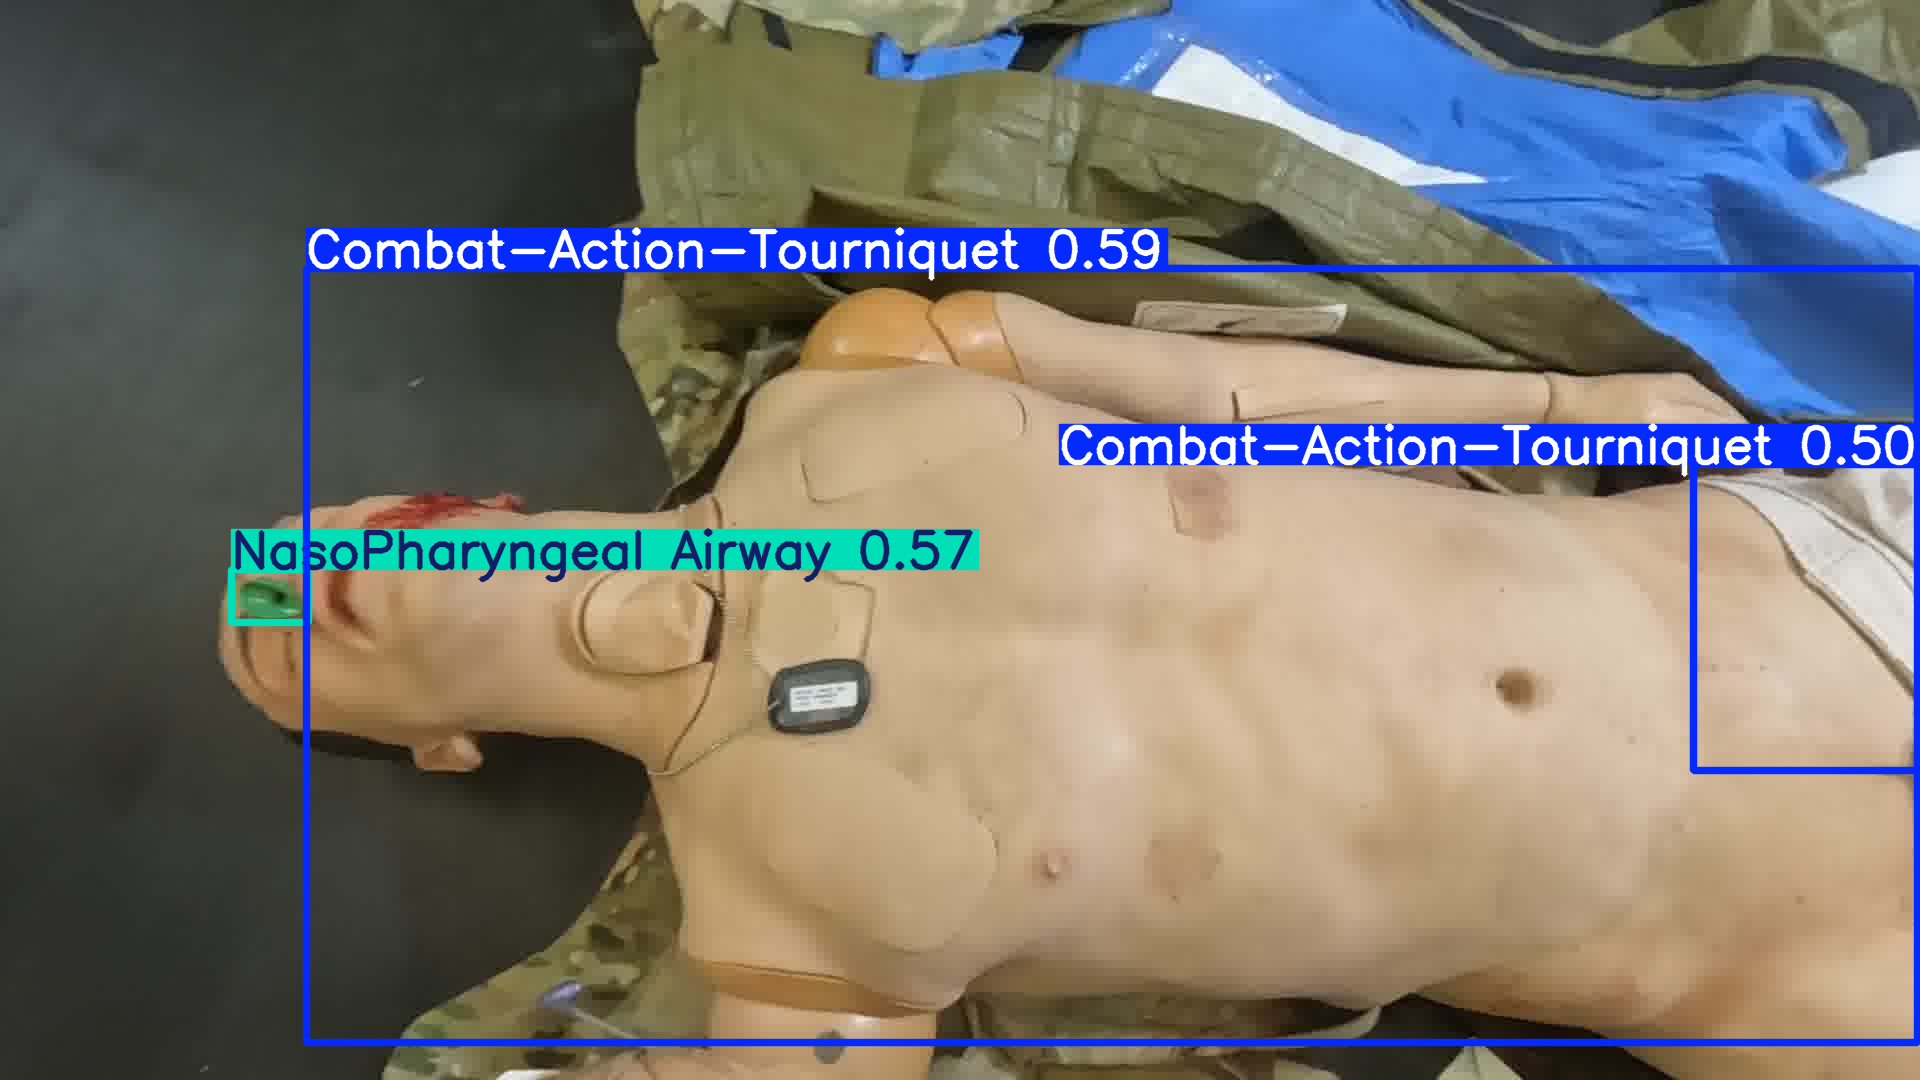

In [10]:
# --- STEP 4: Test Your Custom Model ---

from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import cv2
import random

# Load YOUR custom-trained model from the path where it was saved
model = YOLO('runs/detect/autodoc_yolo_run_1/weights/best.pt')

# Let's find a random image from your test set
test_image_dir = dataset_config['test']
random_test_image = random.choice(os.listdir(test_image_dir))
image_to_test_path = os.path.join(test_image_dir, random_test_image)

print(f"Running detection on random test image: {image_to_test_path}")

# Run inference on the image
results = model(image_to_test_path)

# Plot the results (this draws the boxes and labels on the image)
annotated_image = results[0].plot()

# Display the image with detections
cv2_imshow(annotated_image)

In [13]:
# --- STEP 1: Load the Trained Model ---

from ultralytics import YOLO
import os

# The path to your best trained model
model_path = 'runs/detect/autodoc_yolo_run_1/weights/best.pt'

if os.path.exists(model_path):
    print(f"Loading custom model from: {model_path}")
    model = YOLO(model_path)
else:
    raise FileNotFoundError(f"Could not find the trained model at {model_path}. Please ensure the training completed.")

Loading custom model from: runs/detect/autodoc_yolo_run_1/weights/best.pt


In [14]:
# --- STEP 2: Run Evaluation to Generate Metrics ---

print("Running evaluation on the validation set to generate performance data...")

# The model.val() function does the hard work of calculating all the metrics.
# We will use the 'val' split, which is what the training logs were based on.
metrics = model.val(split='val')

print("\nEvaluation complete! We now have the data to create our plots.")

Running evaluation on the validation set to generate performance data...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 1.6±1.4 ms, read: 16.3±10.5 MB/s, size: 31.7 KB)


val: Scanning /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/labels.cache... 277 images, 0 backgrounds, 0 corrupt: 100%|██████████| 277/277 [00:00<?, ?it/s]

val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images/TATRC_FPPOV_31786.jpg: 3 duplicate labels removed
val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images/TATRC_FPPOV_32143.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images/TATRC_FPPOV_32163.jpg: 4 duplicate labels removed
val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images/TATRC_FPPOV_32451.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images/TATRC_FPPOV_32461.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images/TATRC_FPPOV_32526.jpg: 2 duplicate labels removed
val: /content/drive/MyDrive/DatasetGenerator/DatasetGenerator/downloaded_data/valid/images/TATRC_FPPOV_32615.jpg: 4 duplicate labels removed
val: /content


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.50it/s]


                   all        277       1842       0.77       0.26      0.303      0.191
Combat-Action-Tourniquet        267       1356      0.519        0.4      0.424      0.244
Emergency Trauma Bandage        120        163      0.601      0.461      0.534      0.406
 NasoPharyngeal Airway        109        190       0.73      0.437       0.52       0.29
Needle-Chest-Decompression         46         75          1          0     0.0175    0.00738
IV-UltraSite-Saline-Lock         49         58          1          0     0.0189    0.00478
Speed: 1.1ms preprocess, 4.1ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/val

Evaluation complete! We now have the data to create our plots.


Found results file at: runs/detect/autodoc_yolo_run_1/results.csv


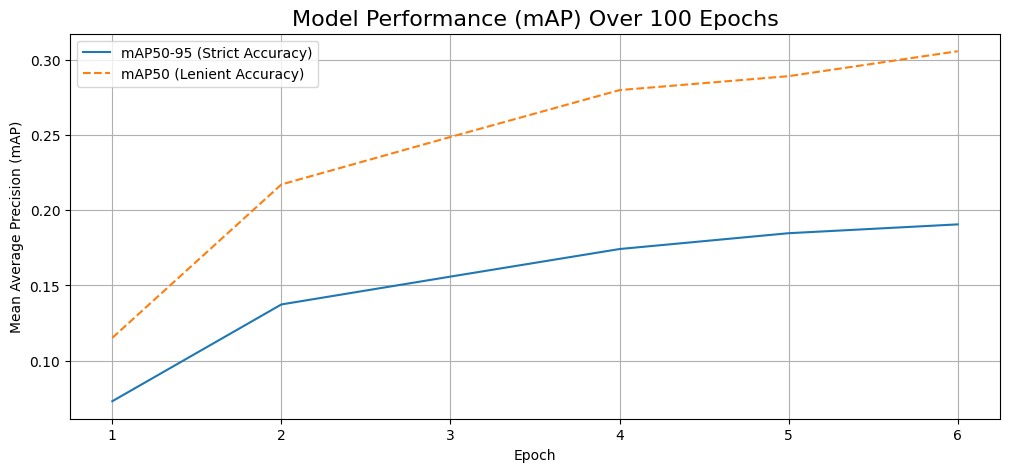

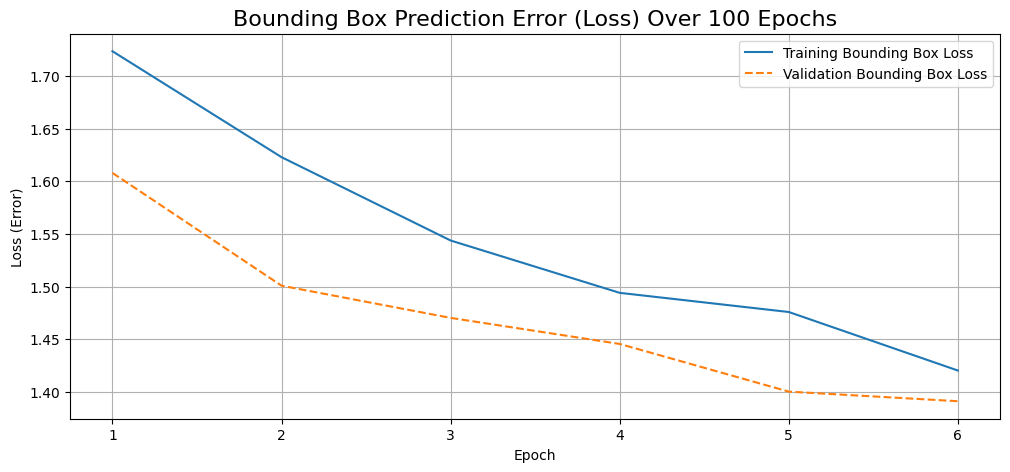

In [19]:
# --- STEP 4: Plot Training History from results.csv ---

import pandas as pd
import matplotlib.pyplot as plt
import os

# The path to your results CSV file, located inside your training run folder
results_csv_path = 'runs/detect/autodoc_yolo_run_1/results.csv'

# First, we check if the file actually exists
if os.path.exists(results_csv_path):
    print(f"Found results file at: {results_csv_path}")

    # Load the data using pandas
    results_df = pd.read_csv(results_csv_path)

    # Clean up column names to remove any extra spaces
    results_df.columns = results_df.columns.str.strip()

    # --- Plot 1: The Main Performance Metric (mAP) ---
    # This chart shows how the model's overall accuracy improved over time.
    # You want to see these lines go UP and then level off.
    plt.figure(figsize=(12, 5))
    plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP50-95 (Strict Accuracy)')
    plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP50 (Lenient Accuracy)', linestyle='--')
    plt.title('Model Performance (mAP) Over 100 Epochs', fontsize=16)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Average Precision (mAP)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Plot 2: The Bounding Box Loss ---
    # "Loss" is a measure of error. This chart shows how the model got better
    # at predicting the precise location of the bounding boxes.
    # You want to see these lines go DOWN and then level off.
    plt.figure(figsize=(12, 5))
    plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Training Bounding Box Loss')
    plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Validation Bounding Box Loss', linestyle='--')
    plt.title('Bounding Box Prediction Error (Loss) Over 100 Epochs', fontsize=16)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Error)')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print(f"❌ ERROR: Could not find 'results.csv' at the path: {results_csv_path}")
    print("This can happen if the training was interrupted before the first epoch completed.")

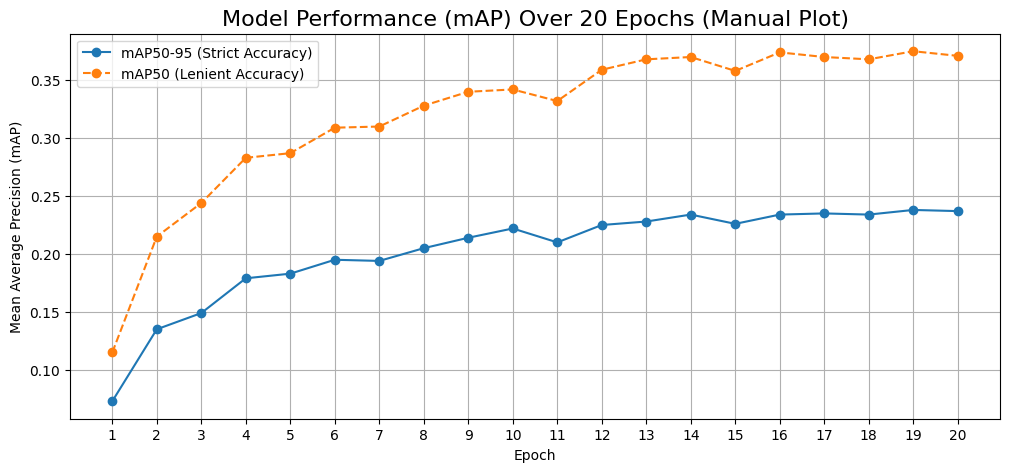

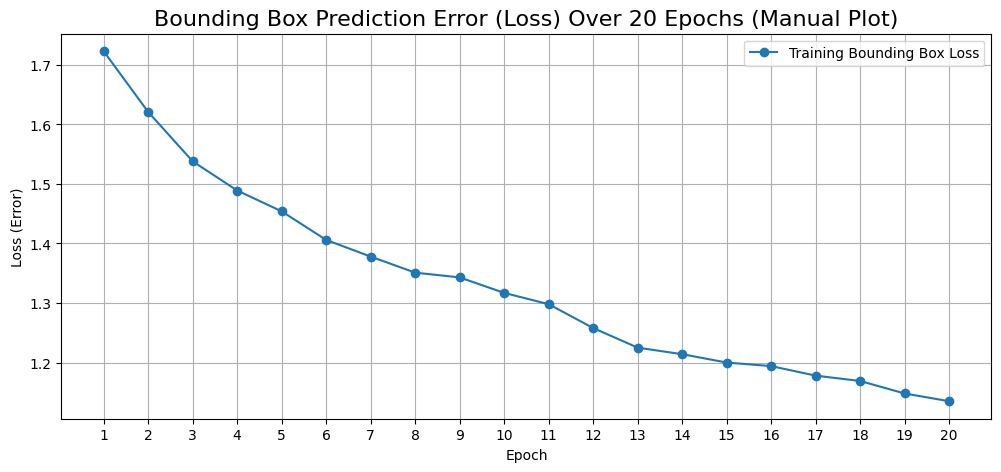

In [2]:
# --- Manually Creating Plots from Your Log Data ---

import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Define the data we manually extracted from your training log
data = {
    'epoch': list(range(1, 21)),
    'box_loss': [1.723, 1.621, 1.538, 1.489, 1.454, 1.406, 1.378, 1.351, 1.343, 1.317, 1.298, 1.258, 1.225, 1.214, 1.200, 1.194, 1.178, 1.169, 1.148, 1.135],
    'mAP50': [0.115, 0.215, 0.244, 0.283, 0.287, 0.309, 0.310, 0.328, 0.340, 0.342, 0.332, 0.359, 0.368, 0.370, 0.358, 0.374, 0.370, 0.368, 0.375, 0.371],
    'mAP50-95': [0.0729, 0.135, 0.149, 0.179, 0.183, 0.195, 0.194, 0.205, 0.214, 0.222, 0.210, 0.225, 0.228, 0.234, 0.226, 0.234, 0.235, 0.234, 0.238, 0.237]
}

# Create a pandas DataFrame from our dictionary
manual_df = pd.DataFrame(data)

# --- Plot 1: The Main Performance Metric (mAP) ---
plt.figure(figsize=(12, 5))
plt.plot(manual_df['epoch'], manual_df['mAP50-95'], label='mAP50-95 (Strict Accuracy)', marker='o')
plt.plot(manual_df['epoch'], manual_df['mAP50'], label='mAP50 (Lenient Accuracy)', linestyle='--', marker='o')
plt.title('Model Performance (mAP) Over 20 Epochs (Manual Plot)', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Mean Average Precision (mAP)')
plt.xticks(range(1, 21)) # Ensure we see every epoch number
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: The Bounding Box Loss ---
# Note: This only shows training loss, as validation loss wasn't in the main log lines.
plt.figure(figsize=(12, 5))
plt.plot(manual_df['epoch'], manual_df['box_loss'], label='Training Bounding Box Loss', marker='o')
plt.title('Bounding Box Prediction Error (Loss) Over 20 Epochs (Manual Plot)', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Loss (Error)')
plt.xticks(range(1, 21)) # Ensure we see every epoch number
plt.legend()
plt.grid(True)
plt.show()